In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pyarrow.parquet as pq
import polars as pl

In [8]:
train_events = pd.read_csv('../../train_events.csv')

#Read file with chunks
#chunksize = 100000
#train_series = pq.ParquetFile('../../train_series.parquet')
#for batch in train_series.iter_batches(batch_size=chunksize):
#    train_series_chunk = batch.to_pandas()

train_series = pd.read_csv('../../filtered_train_series.csv')

test_series = pq.read_table('../../test_series.parquet').to_pandas()

## train_events

In [9]:
train_events = train_events.dropna(subset=['timestamp'])

In [10]:
# Créer une table pivot pour aligner les événements 'onset' et 'wakeup' dans chaque nuit pour chaque 'series_id'
sleep_durations = train_events.pivot_table(index=['series_id', 'night'], 
                                           columns='event', 
                                           values='step').reset_index()

# Calculer la durée de sommeil
sleep_durations['sleep_duration'] = sleep_durations['wakeup'] - sleep_durations['onset']

# Joindre la durée de sommeil au DataFrame 'train_events'
train_events = train_events.merge(sleep_durations[['series_id', 'night', 'sleep_duration']], 
                                  on=['series_id', 'night'], 
                                  how='left')

In [12]:
# Conversion de la colonne timestamp en type datetime
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')

# Vérifier les valeurs non converties (NaT) dans la colonne timestamp
print(f"Nombre de valeurs NaT après conversion: {train_events['timestamp'].isna().sum()}")

# Retirer les lignes avec NaT dans la colonne timestamp si elles perturbent l'analyse
train_events = train_events.dropna(subset=['timestamp'])

# Extraire les caractéristiques temporelles
train_events['hour'] = train_events['timestamp'].dt.hour
train_events['day'] = train_events['timestamp'].dt.day
train_events['month'] = train_events['timestamp'].dt.month
train_events['weekday'] = train_events['timestamp'].dt.weekday
train_events['is_weekend'] = (train_events['weekday'] >= 5).astype(int)

Nombre de valeurs NaT après conversion: 4043


In [13]:
# Encodage de la colonne 'event' en variables binaires
train_events = pd.get_dummies(train_events, columns=['event'], prefix='event', drop_first=True)


In [14]:
# Trier les données par 'series_id', 'night', et 'timestamp' pour s'assurer que les événements sont dans l'ordre
train_events = train_events.sort_values(by=['series_id', 'night', 'timestamp']).reset_index(drop=True)

# Calculer l'intervalle de temps (en heures) depuis l'événement précédent
train_events['time_since_last_event'] = train_events.groupby(['series_id', 'night'])['timestamp'].diff().dt.total_seconds() / 3600

# Calculer l'intervalle de 'step' depuis l'événement précédent
train_events['step_since_last_event'] = train_events.groupby(['series_id', 'night'])['step'].diff()


In [15]:
# Compter le nombre d'événements par nuit
event_counts = train_events.groupby(['series_id', 'night']).size().reset_index(name='events_per_night')

# Joindre les comptages d'événements au DataFrame principal
train_events = train_events.merge(event_counts, on=['series_id', 'night'], how='left')


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser la colonne 'step'
scaler = MinMaxScaler()
train_events['step_normalized'] = scaler.fit_transform(train_events[['step']])

# Indicateur pour les 'step' au-delà de 650000 (outliers)
train_events['step_outlier'] = (train_events['step'] > 650000).astype(int)


In [17]:
# Indicateurs pour les nuits plus courtes ou plus longues que la moyenne de 9 heures
train_events['short_sleep'] = (train_events['sleep_duration'] < 9 * 3600).astype(int)
train_events['long_sleep'] = (train_events['sleep_duration'] > 9 * 3600).astype(int)


In [18]:
# Calculer la durée totale par nuit
night_aggregates = train_events.groupby(['series_id', 'night']).agg(
    total_sleep_duration=('sleep_duration', 'sum'),
    avg_time_between_events=('time_since_last_event', 'mean'),
    variance_time_between_events=('time_since_last_event', 'var')
).reset_index()

# Joindre les agrégats par nuit au DataFrame principal
train_events = train_events.merge(night_aggregates, on=['series_id', 'night'], how='left')


Recapitulatif des features :

Durée de sommeil (sleep_duration) : Calculée comme la différence entre onset et wakeup.  
Caractéristiques temporelles : hour, day, month, weekday, et is_weekend.  
Encodage d’événements : Variables binaires pour onset et wakeup.  
Intervalles entre événements : Temps (time_since_last_event) et step entre chaque événement.  
Nombre d'événements par nuit (events_per_night) : Indicateur de fragmentation.  
Caractéristiques step : step_normalized, step_outlier.  
Indicateurs de durée de sommeil : short_sleep et long_sleep en fonction de la moyenne de 9 heures.  
Caractéristiques agrégées par nuit : Durée totale du sommeil, moyenne et variance des intervalles entre événements.  

### Visualition

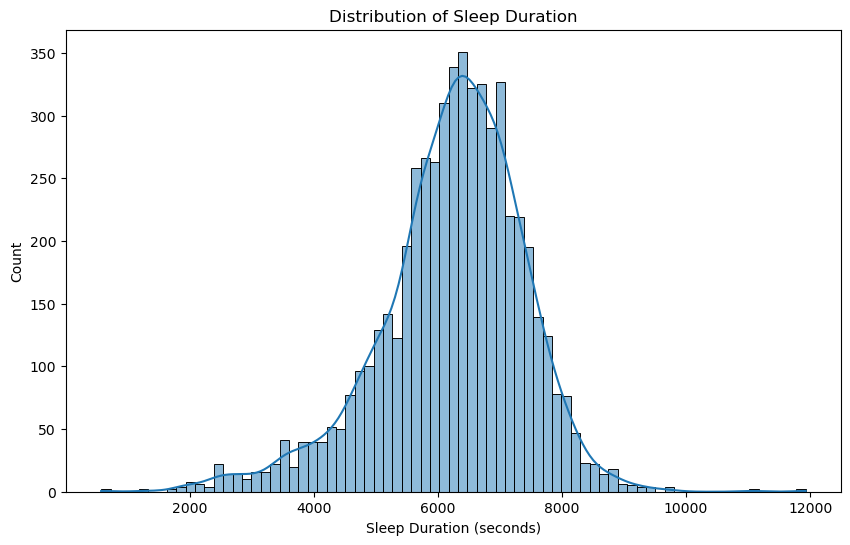

In [20]:
#Visualisation distribution durée de sommeil

plt.figure(figsize=(10, 6))
sns.histplot(train_events['sleep_duration'].dropna(), kde=True)
plt.title('Distribution of Sleep Duration')
plt.xlabel('Sleep Duration (seconds)')
plt.show()

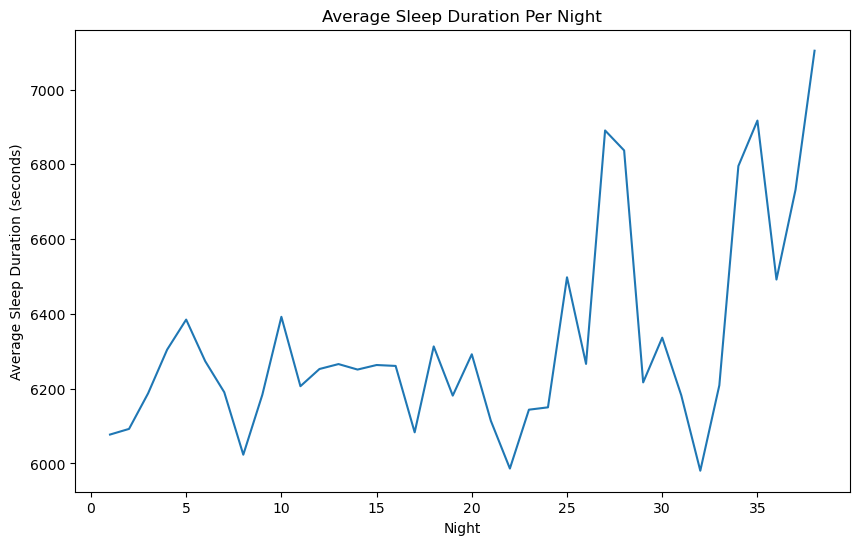

In [24]:
avg_sleep_per_night = train_events.groupby('night')['sleep_duration'].mean()
plt.figure(figsize=(10, 6))
avg_sleep_per_night.plot(kind='line')
plt.title('Average Sleep Duration Per Night')
plt.xlabel('Night')
plt.ylabel('Average Sleep Duration (seconds)')
plt.show()


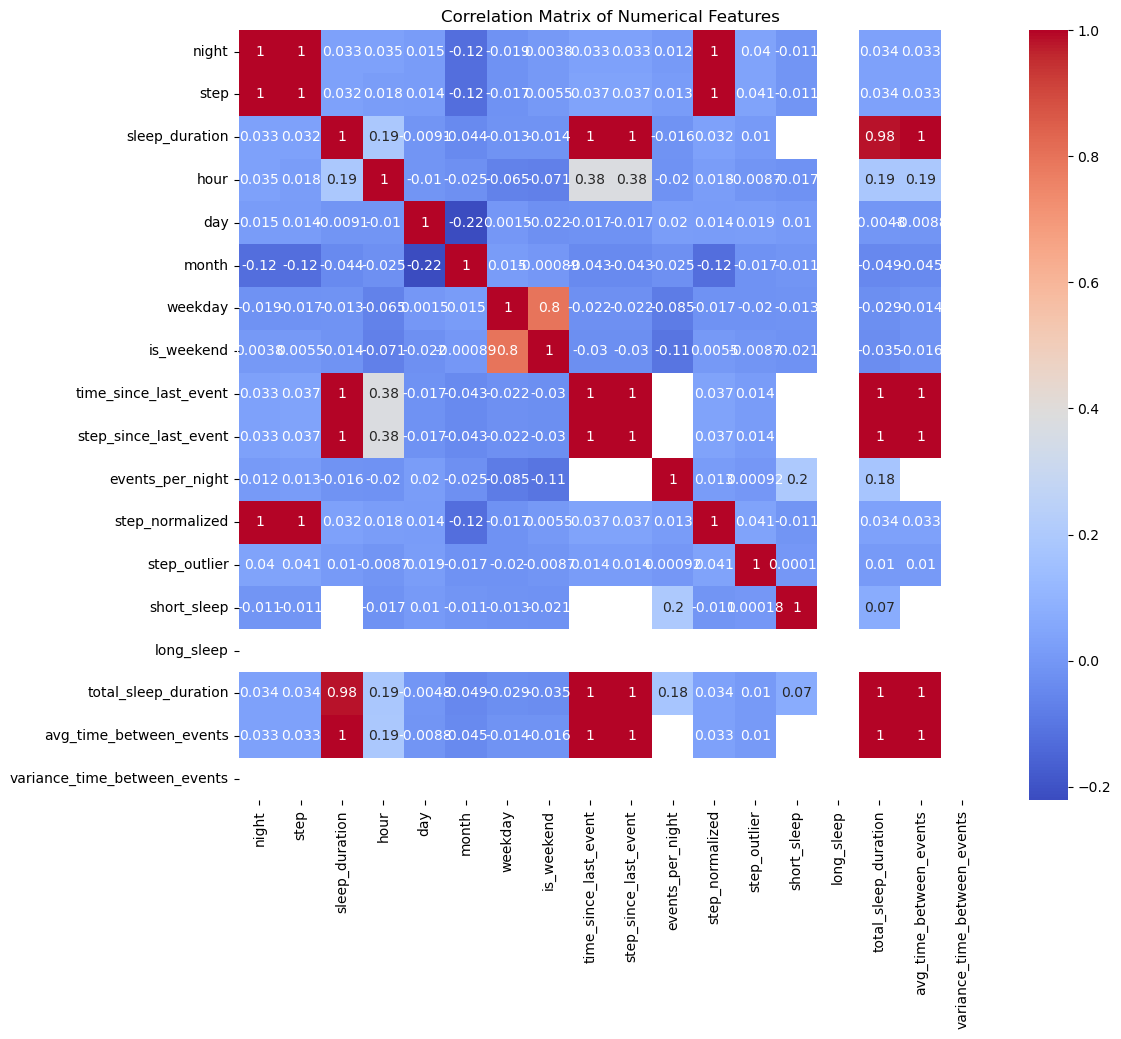

In [27]:
# Sélectionner uniquement les colonnes numériques pour la corrélation
numerical_features = train_events.select_dtypes(include=[float, int])

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Suppression des colonnes non numériques et des identifiants non nécessaires
X = train_events.drop(columns=['short_sleep', 'series_id', 'timestamp'])  # Supprimez aussi 'timestamp'

# Vérification des types de données pour s'assurer qu'il ne reste que des colonnes numériques
#print(X.dtypes)

# Si des colonnes catégorielles existent encore, encodez-les en numériques
# Ex : One-hot encoding si nécessaire
X = pd.get_dummies(X, drop_first=True)

# Diviser les données en ensemble d'entraînement et de test
y = train_events['short_sleep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Importance des features
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)



                         feature  importance
2                 sleep_duration    0.444808
15          total_sleep_duration    0.287816
12               step_normalized    0.054653
4                            day    0.054115
0                          night    0.048287
1                           step    0.045772
11              events_per_night    0.028744
16       avg_time_between_events    0.018622
5                          month    0.015432
3                           hour    0.001346
6                        weekday    0.000251
7                     is_weekend    0.000156
14                    long_sleep    0.000000
9          time_since_last_event    0.000000
13                  step_outlier    0.000000
10         step_since_last_event    0.000000
8                   event_wakeup    0.000000
17  variance_time_between_events    0.000000


In [30]:
print(train_events.columns)


Index(['series_id', 'night', 'step', 'timestamp', 'sleep_duration', 'hour',
       'day', 'month', 'weekday', 'is_weekend', 'event_wakeup',
       'time_since_last_event', 'step_since_last_event', 'events_per_night',
       'step_normalized', 'step_outlier', 'short_sleep', 'long_sleep',
       'total_sleep_duration', 'avg_time_between_events',
       'variance_time_between_events'],
      dtype='object')


In [37]:
# Créer la colonne 'event_onset' comme l'inverse de 'event_wakeup'
train_events['event_onset'] = 1 - train_events['event_wakeup']


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Suppression des colonnes non numériques et des identifiants non nécessaires
X = train_events.drop(columns=['event_onset', 'event_wakeup', 'series_id', 'timestamp'])  # Exclure les colonnes cible et identifiants
y = train_events['event_onset']  # Utiliser 'event_onset' comme cible

# Encodage des éventuelles colonnes catégorielles restantes
X = pd.get_dummies(X, drop_first=True)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner un modèle Random Forest pour obtenir les importances des features
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Importance des features
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Afficher les résultats
print(feature_importances)


                         feature  importance
8          time_since_last_event    0.398898
9          step_since_last_event    0.376862
3                           hour    0.199956
1                           step    0.005633
11               step_normalized    0.004248
16       avg_time_between_events    0.003160
15          total_sleep_duration    0.002208
10              events_per_night    0.001926
2                 sleep_duration    0.001773
5                          month    0.001536
0                          night    0.001157
4                            day    0.001058
6                        weekday    0.000923
7                     is_weekend    0.000663
12                  step_outlier    0.000000
13                   short_sleep    0.000000
14                    long_sleep    0.000000
17  variance_time_between_events    0.000000


In [40]:
# Conserver uniquement les features pertinentes
important_features_onset = feature_importances[feature_importances['importance'] > 0]['feature'].tolist()
X_reduced = X[important_features_onset]

In [41]:
# Diviser les données avec les features réduites
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Entraîner le modèle avec les features réduites
model_reduced = RandomForestClassifier(random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Prédictions et évaluation
y_pred_reduced = model_reduced.predict(X_test_reduced)
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy avec features réduites:", accuracy_score(y_test, y_pred_reduced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced))


Accuracy avec features réduites: 1.0

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       821
        True       1.00      1.00      1.00       842

    accuracy                           1.00      1663
   macro avg       1.00      1.00      1.00      1663
weighted avg       1.00      1.00      1.00      1663



In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Suppression des colonnes non numériques et des identifiants non nécessaires
X = train_events.drop(columns=['event_onset', 'event_wakeup', 'series_id', 'timestamp'])  # Exclure les colonnes cible et identifiants
y = train_events['event_wakeup']  # Utiliser 'event_onset' comme cible

# Encodage des éventuelles colonnes catégorielles restantes
X = pd.get_dummies(X, drop_first=True)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner un modèle Random Forest pour obtenir les importances des features
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Importance des features
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Afficher les résultats
print(feature_importances)


                         feature  importance
8          time_since_last_event    0.398898
9          step_since_last_event    0.376862
3                           hour    0.199956
1                           step    0.005633
11               step_normalized    0.004248
16       avg_time_between_events    0.003160
15          total_sleep_duration    0.002208
10              events_per_night    0.001926
2                 sleep_duration    0.001773
5                          month    0.001536
0                          night    0.001157
4                            day    0.001058
6                        weekday    0.000923
7                     is_weekend    0.000663
12                  step_outlier    0.000000
13                   short_sleep    0.000000
14                    long_sleep    0.000000
17  variance_time_between_events    0.000000


In [44]:
# Conserver uniquement les features pertinentes
important_features_wakeup = feature_importances[feature_importances['importance'] > 0]['feature'].tolist()
X_reduced_wakeup = X[important_features_wakeup]

In [45]:
# Diviser les données avec les features réduites
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced_wakeup, y, test_size=0.3, random_state=42)

# Entraîner le modèle avec les features réduites
model_reduced = RandomForestClassifier(random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Prédictions et évaluation
y_pred_reduced = model_reduced.predict(X_test_reduced)
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy avec features réduites:", accuracy_score(y_test, y_pred_reduced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced))


Accuracy avec features réduites: 1.0

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       821
        True       1.00      1.00      1.00       842

    accuracy                           1.00      1663
   macro avg       1.00      1.00      1.00      1663
weighted avg       1.00      1.00      1.00      1663

